<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC3
Crop type feature engineering

In [1]:
import openeo
from openeo.processes import ProcessBuilder, array_modify
from openeo.rest.conversions import timeseries_json_to_pandas
from eo_utils import *
from matplotlib import pyplot as plt
from shapely.geometry import box
import pandas as pd
from helper import compute_indices
import geopandas as gpd
from openeo.processes import divide, subtract, multiply, add

def lin_scale_range(x,inputMin,inputMax,outputMin,outputMax):
    return add(multiply(divide(subtract(x,inputMin), subtract(inputMax, inputMin)), subtract(outputMax, outputMin)), outputMin)

c:\users\driesseb\.conda\envs\openeo\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In this notebook we will perform an easy rule-based classification for 5 crop types.
First, we will select a plot and load in Sentinel-1 and 2 data. Then we will calculate the NDVI for the plot you selected, and have a look at the temporal NDVI profile of different crop types and see how the user-defined plot selected on a map compares. 

Afterwards, we will have a look at a small dataset of 5 crop types with 10 ground truth samples each, and plot the NDVI as well as a number of spectral bands for each of these ground truth samples. These plots will be used to derive some rules manually. The rules are subsequently used to perform a rough crop classification, and the results are plotted.

Step 1: Select a polygon on the map below. For the sake of the analysis below, make sure your polygon covers just one land use type (for example, a forest, a field or a small group of fields).

In [2]:
center = [50.8, 4.75]
zoom = 13

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[50.8, 4.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [20]:
bbox = eoMap.getBbox()

Fill in the land cover type that you think the polygon you selected contains, and a year for which to run the analysis.

Note: the ground truth data used in this study is from 2019, so if you select a different year you will have to provide your own ground truth data from the year you have selected.

In [4]:
lc_polygon = "Potato"
year = 2019

connection = openeo.connect("https://openeo-dev.vito.be")
# connection.authenticate_oidc()
connection.authenticate_basic("bart","bart123")

<Connection to 'https://openeo-dev.vito.be/openeo/1.0/' with BearerAuth>

## Load the dataset

Step 2: *Connect* to the vito backend and load Sentinel-2 bands 4 (RED), 8 (NIR), 11 (SWIR) and the scene classification layer (SCL). This last layer will be used for cloud masking. We will not specify a spatial filter for now as a spatial filter will be applied later on.
After that, we will use the scene classification band to perform *cloud masking* and drop the SCL layer as we will not need it anymore.

We use a temporal range that is slightly bigger than the actual temporal range we need to improve the interpolation.

In [5]:
temp_ext = [str(year-1)+"-11-01", str(year+1)+"-02-01"]

temporal_partition_options = {
        "indexreduction": 0,
        "temporalresolution": "None",
        "tilesize": 256
    }
default_partition_options = {
    "tilesize": 256
}

s2 = connection.load_collection("TERRASCOPE_S2_TOC_V2",                                 
                                temporal_extent=temp_ext,
                                bands=["B04","B08","B11","SCL"])
s2._pg.arguments['featureflags'] = temporal_partition_options
s2_masked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL").filter_bands(["B04", "B08", "B11"])

Step 3: To make a similar seasonal plot for the area you selected in the map above, we want to first calculate a vegetation index such as the NDVI or the EVI. To do so, we need to define a callback function that can be passed to the process parameter of apply_dimension.

Adding the NDVI index is the first step. We do this before compositing, to avoid computing an NDVI on unobserved band combinations.

After computing the NDVI, our datacube is holding double precision floating point numbers, at 8bytes per value. This requires a lot of memory in subsequent steps.
We scale the back to byte values, which only use 1 byte. Using 2-byte integers would also be an option if 1 byte is not sufficient. The theoretical maxium of Sentinel-2 band values is 0-10000, however in practice the maximum would be around 2000. We take 6000 to make sure we do not cut off any values.

This optimization can not be done automatically, because openEO is not aware of the desired precision.

After that, we calculate the monthly aggregates and interpolate to impute any months for which no data is available.

In [7]:
ndvi_comp = compute_indices(s2_masked, ["NDVI"],6000)
ndvi_comp_byte = ndvi_comp.apply_dimension(dimension="bands",process=lambda x: lin_scale_range(x, 0,6000,0,250))
agg_month = ndvi_comp_byte.aggregate_temporal_period(period="month", reducer="mean")
ndvi_month = agg_month.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year+1)+"-01-01"])

We will also load in Sentinel-1 data, which will be used later on in some of the crop rules.

In [17]:
s1 = connection.load_collection("S1_GRD_SIGMA0_ASCENDING",                                 
                                temporal_extent=[str(year)+"-01-01", str(year+1)+"-01-01"], 
                                bands=["VH","VV"]
                               )
s1._pg.arguments['featureflags'] = temporal_partition_options

composite_s1 = s1.apply_dimension(dimension="bands",process=lambda x: array_modify(data=x, values=x.array_element(0)/x.array_element(1), index=0))
composite_s1 = composite_s1.apply_dimension(dimension="bands", process=lambda x: lin_scale_range(x,0,1,0,250))

s1_month = composite_s1.aggregate_temporal_period(period="month", reducer="mean")
s1_month = s1_month.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year+1)+"-01-01"])
s1_month = s1_month.resample_cube_spatial(ndvi_comp)

Step 4: Next, we merge the NDVI & Sentinel-2 composite with the Sentinel-1 data.

In [18]:
ndvi_comp_sar = ndvi_month.merge_cubes(s1_month).rename_labels("bands",ndvi_month.metadata.band_names + ["ratio","VV","VH"]).filter_bands(ndvi_month.metadata.band_names+["ratio"])

## Timeseries analysis of vegetation greenness

For this use case, we first want to have a look at vegetation greenness over time. Different land cover types can be identified by their seasonal greenup / greendown patterns. For example, coniferous forests are green all year round and have little variation in  greenness over time, while crops like sugar beet and maize are characterized by strong seasonal fluctuations. An overview of several crops types is displayed below.

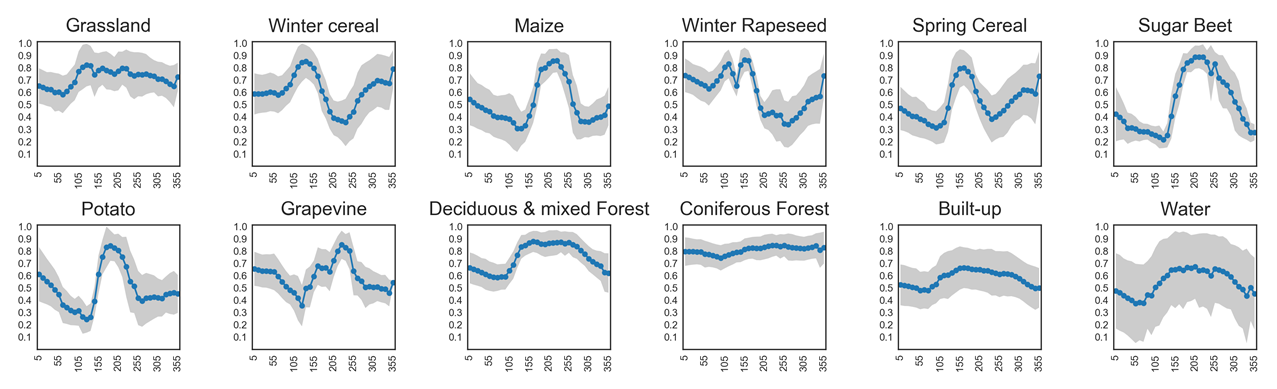

We will now apply a spatial filter using the bbox you selected on the map and only keep the NDVI band.

In [9]:
agg_dekad = ndvi_comp_byte.aggregate_temporal_period(period="dekad", reducer="mean")
ndvi_dekad = agg_dekad.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])
ndvi_bbox = ndvi_dekad.filter_spatial(geometries=box(*bbox)).filter_bands(["NDVI"])

Step 5: This NDVI is calculated for every pixel in every time step t in the masked NIR/red image that we extracted from SentinelHub. Now we want to aggregate the polygon you selected spatially to end up with a timeseries by calculating the mean over all the pixels as well as the standard deviation, to have an indication of the error. The more homogeneous the area you selected is, the smaller your error will be.

In [10]:
timeseries = ndvi_bbox.aggregate_spatial(reducer="mean", geometries=box(*bbox)).execute()
timeseries_sd = ndvi_bbox.aggregate_spatial(reducer="sd", geometries=box(*bbox)).execute()

Finally, we can plot the mean and standard deviation for the plot you selected. Compare your results with the image above. Are your results as expected? Feel free to select a polygon on the map and run the code once more to compare your results.

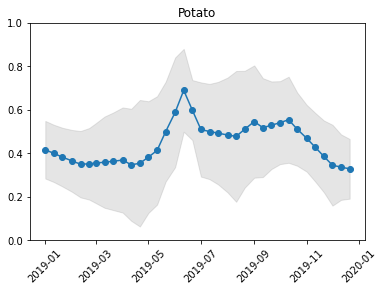

In [11]:
timeser = pd.concat([timeseries_json_to_pandas(timeseries),timeseries_json_to_pandas(timeseries_sd)], axis=1).dropna() / 250
timeser.columns = ["Mean NDVI", "SD"]
timeser.index = pd.to_datetime(timeser.index)
timeser = timeser.sort_index()

plt.plot(timeser["Mean NDVI"],"o-")
plt.fill_between(timeser.index,
                 timeser["Mean NDVI"] - timeser["SD"], 
                 timeser["Mean NDVI"] + timeser["SD"],
                 color='gray', alpha=0.2)
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title(lc_polygon)
plt.show()

## Creating rules for rule-based classification

In the following section, we will proceed to creating the rules that will be used for classification. These rules will be determined by plotting the spectral profile as well as the NDVI for a number of crops, and these crop locations are known through a reference dataset containing ground truth observations spread over Belgium. The 10 samples per crop that are visualized were randomly selected.

#### Reference dataset

For this use case, we use harmonized LPIS data from the ESA WorldCereal project. The following crop types are of interest, with their code in the legend:
- **maize: 1200**
- winter wheat: 1110
- spring wheat: 1120
- **barley: 1500** (winter barley: 1510, spring barley: 1520)
- **potatos: 5100**
- **sugar beet: 8100**
- rapeseed: 4350 (winter rapeseed: 4351, spring rapeseed: 4352)
- sunflower: 4380
- **soy bean: 4100**

For this project, we will focus on the five crop types delineated in bold: maize (corn), potato, sugarbeet, barley and soy.

In [10]:
crops = {"maize":1200,"potatos":5100,"sugarbeet":8100,"barley":1500,"soy":4100}
crop_samples = {name:gpd.read_file("UC3_resources/"+ name + "_2019.geojson", driver='GeoJSON') for name,code in crops.items()}

### Retrieve timeseries

First, we will calculate monthly aggregates of NDVI, VNIR-SWIR and SAR. Next, we will plot them to help in determining crop calendar rules.

In [11]:
for name,crop_df in crop_samples.items():    
    ndvi_comp_sar.aggregate_spatial(reducer="mean", geometries=crop_df.__geo_interface__).download("data/" + name + "_mean_comp.json")

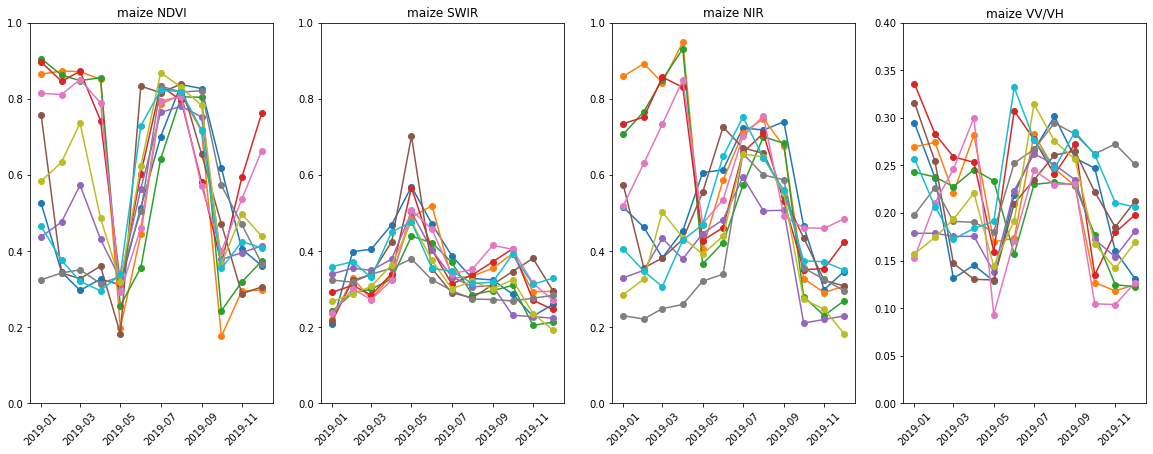

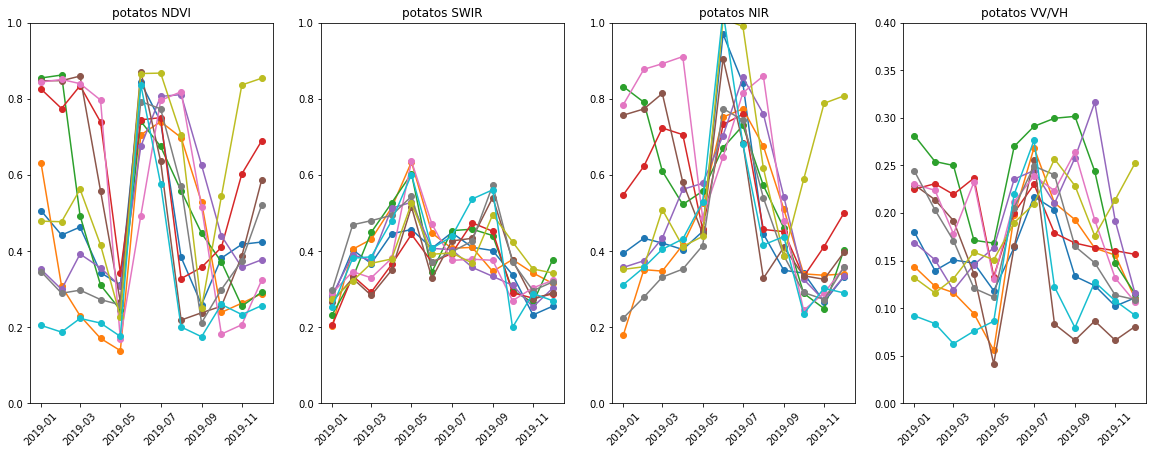

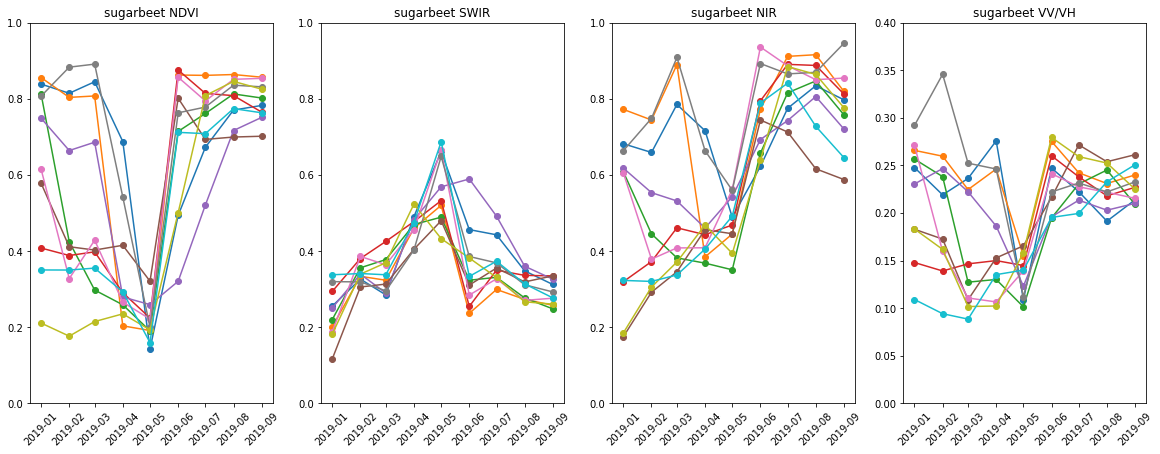

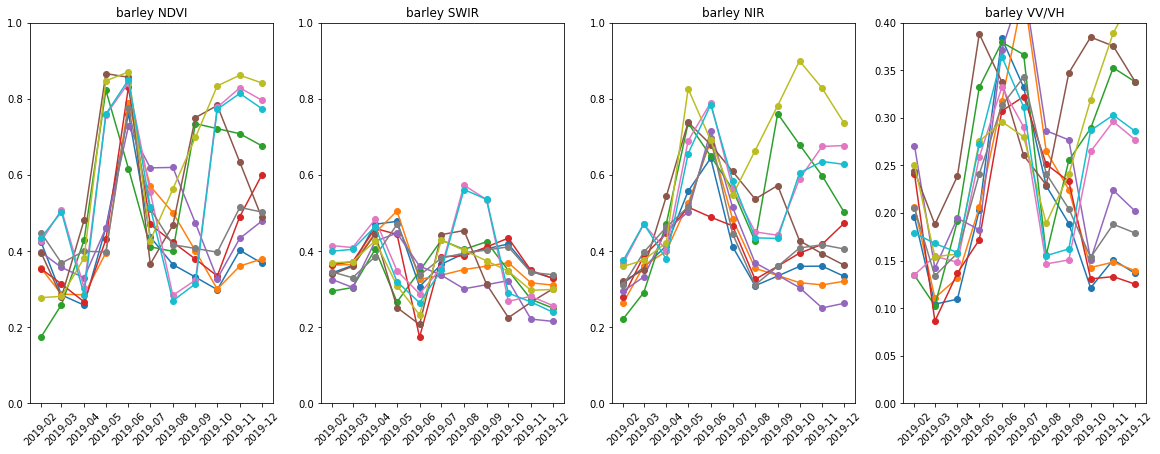

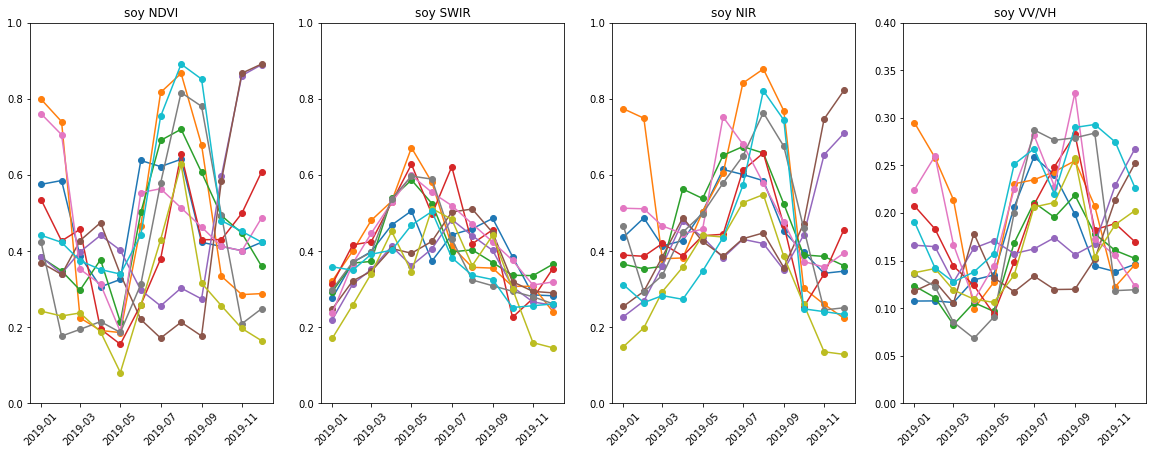

In [16]:
for name,crop_df in crop_samples.items(): 
    file = "data/" + name + "_mean_comp.json"
    with open(file) as f:
        ts_json = json.load(f)
    timeser = timeseries_json_to_pandas(ts_json)
    
    timeser.index = pd.to_datetime(timeser.index)
    timeser = timeser.sort_index().dropna() / 250
    
    NDVI = timeser.xs(3, level='band', axis=1)
    NIR = timeser.xs(1, level='band', axis=1)
    SWIR = timeser.xs(2, level='band', axis=1)
    ratio = timeser.xs(4, level='band', axis=1)
    
    fig, (ax1, ax2,ax3, ax4) = plt.subplots(1,4)
    plt.setp([ax1.get_xticklabels(), ax2.get_xticklabels(), ax3.get_xticklabels(), ax4.get_xticklabels()], rotation=45)
    fig.set_figheight(7); fig.set_figwidth(20)

    ax1.plot(NDVI,"o-")
    ax1.set_ylim(0,1)
    ax1.set_title(name + " NDVI")
    fig.show()
    
    ax2.plot(SWIR,"o-")    
    ax2.set_ylim(0,1)
    ax2.set_title(name + " SWIR")
    
    ax3.plot(NIR,"o-")
    ax3.set_ylim(0,1)
    ax3.set_title(name + " NIR")

    ax4.plot(ratio,"o-")
    ax4.set_ylim(0,0.4)
    ax4.set_title(name + " VV/VH")
    
    fig.show()    

## Rule based stratification

Now it is time to put the rules we visually determined into practice. First, determine whether you want to use SAR bands in your rules.

In [21]:
run_with_SAR = True

### Crop detection rules

In this use case, we have defined so called 'expert rules' based on crop calendars and an analysis of time series profiles, to determine a crop type based on temporal behaviour.

The rules in this notebook have not been validated, and were mostly verified in Belgium. Crop calendar based rules are region depended, and can even change over time for the same region.


In [22]:
all_bands = ndvi_comp_sar.apply_dimension(dimension='t', target_dimension='bands', process=lambda x: x*1)
bandnames2 = [band + "_" + stat for stat in ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"] for band in all_bands.metadata.band_names]
bandnames = [band + "_" + stat for band in all_bands.metadata.band_names for stat in ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]]
all_bands = all_bands.rename_labels('bands', target=bandnames)

ndvi_apr = all_bands.band("NDVI_apr")
ndvi_may = all_bands.band("NDVI_may")
ndvi_jun = all_bands.band("NDVI_jun")
ndvi_jul = all_bands.band("NDVI_jul")
ndvi_aug = all_bands.band("NDVI_aug")
ndvi_sep = all_bands.band("NDVI_sep")
ndvi_oct = all_bands.band("NDVI_oct")
ndvi_nov = all_bands.band("NDVI_nov")

nir_mar = all_bands.band("B08_mar")
nir_may = all_bands.band("B08_may")
nir_jun = all_bands.band("B08_jun")
nir_oct = all_bands.band("B08_oct")
swir_mar = all_bands.band("B11_mar")
swir_may = all_bands.band("B11_may")
swir_oct = all_bands.band("B11_oct")
    
## Rule for corn is not in line with experiment for 2019, use ndvi_may < ndvi_jun
corn = (((ndvi_may < ndvi_jun) + (ndvi_sep > ndvi_nov) + (nir_mar > swir_may) + (swir_mar > nir_may)) == 4)*1
barley = (((ndvi_apr < ndvi_may) + (ndvi_jul < ndvi_jun)) == 2)*1 ## barley has very narrow and early NDVI 
sugarbeet = (((ndvi_may < 0.6*ndvi_jun) + ((ndvi_jun+ndvi_jul+ndvi_aug+ndvi_sep)/4 > 0.7))==2)*1 #4 month period of high NDVI
potato = ((((ndvi_jun/ndvi_may) > 2) + (ndvi_sep < ndvi_jul) + (ndvi_nov > (ndvi_sep + ndvi_oct)/2) + ((swir_may / nir_may) > 0.8) + ((nir_jun / nir_may) > 1.5)) == 5)*1
soy = ((((ndvi_may / ndvi_apr) < 1.2) + ((ndvi_may / ndvi_apr) > 0.8) + (ndvi_sep < ndvi_aug) + ((nir_oct / swir_oct) < 1.1)) == 4)*1

if run_with_SAR:
    apr_rat = all_bands.band("ratio_apr")
    may_rat = all_bands.band("ratio_may")
    jun_rat = all_bands.band("ratio_jun")
    jul_rat = all_bands.band("ratio_jul")
    aug_rat = all_bands.band("ratio_aug")
    sep_rat = all_bands.band("ratio_sep")
    oct_rat = all_bands.band("ratio_oct")
    corn = (corn + ((jul_rat + aug_rat + sep_rat)/3 > (jun_rat + oct_rat)/2) == 2)
    potato = (potato + ((jun_rat + jul_rat)/2 > aug_rat) == 2)
    sugarbeet = (sugarbeet + ((jun_rat + jul_rat + aug_rat + sep_rat + oct_rat)/may_rat > 2) == 2)
    barley = (barley + (jun_rat > aug_rat) + (jun_rat/apr_rat)>1.5 == 3)
    soy = (soy + (jun_rat/(apr_rat + may_rat)>1.5) == 2)

total = 1*corn + 2*barley + 4*sugarbeet + 8*potato + 16*soy #allow multiple crops to be detected...

In [23]:
total.filter_bbox({'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]})\
    .download("./data/total.tif",format="GTiff")

['none', 'corn', 'sugarbeet', 'sugarbeet corn', 'potato sugarbeet', 'soy']


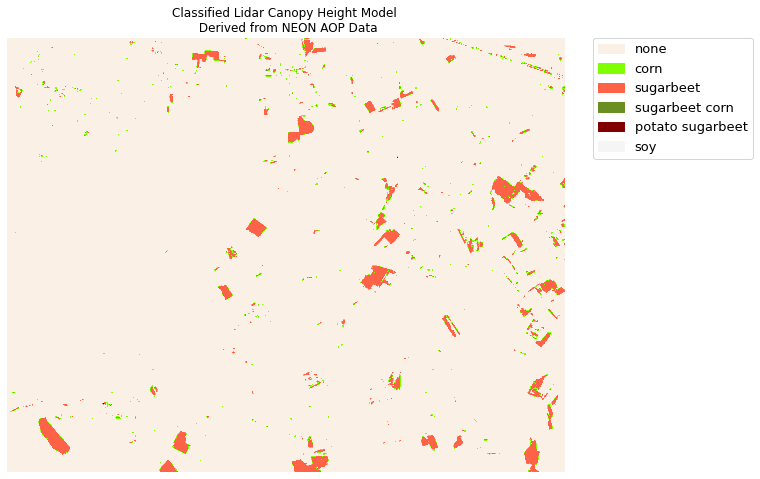

In [24]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import earthpy.plot as ep

comb = {0: "none",
        1: "corn",
       2: "barley",
        3: "corn barley",
       4: "sugarbeet",
        5: "sugarbeet corn",
        6: "sugarbeet barley",
        7: "sugarbeet barley corn",
       8: "potato",
        9: "potato corn",
        10: "potato barley",
        11: "potato barley corn",
        12: "potato sugarbeet",
        13: "potato sugarbeet corn",
        14: "potato sugarbeet barley",
        15: "potato sugarbeet barley corn",
       16: "soy",
        17: "soy corn",
        18: "soy barley",
        19: "soy barley corn",
        20: "soy sugarbeet",
        21: "soy sugarbeet corn",
        22: "soy sugarbeet barley",
        23: "soy sugarbeet barley corn",
        24: "soy potato",
        25: "soy potato corn",
        26: "soy potato barley",
        27: "soy potato barley corn",
        28: "soy potato sugarbeet",
        29: "soy potato sugarbeet corn",
        30: "soy potato sugarbeet barley",
        31: "soy potato sugarbeet barley corn"
       }

with rasterio.open('./data/total.tif',mode="r+",crs=rasterio.crs.CRS({"init": "epsg:4326"})) as dataset:
    keys = np.unique(dataset.read()).astype(int)
    height_class_labels = [comb[key] for key in comb.keys() if key in keys]
    print(height_class_labels)

    colors = ['linen',
             'chartreuse',
             'tomato',
             'olivedrab',
             'maroon',
             'whitesmoke',
             'wheat',
             'palevioletred',
             'darkturquoise',
             'tomato',
             'thistle',
             'teal',
             'darkgoldenrod',
             'darkmagenta',
             'darkorange',
             'sienna',
             'black',
             'silver',
             'tan',
             'seagreen',
             'mediumspringgreen',
             'lightseagreen',
             'royalblue',
             'mediumpurple',
             'plum',
             'darkcyan',
             'moccasin',
             'rosybrown',
             'gray',
             'sandybrown',
             'm',
             'navy'][0:len(height_class_labels)]

    cmap = ListedColormap(colors)

    class_bins = [-0.5]+[i+0.5 for i in keys]
    norm = BoundaryNorm(class_bins, len(colors))

    f, ax = plt.subplots(figsize=(10, 8))  
    im = ax.imshow(dataset.read(1), cmap=cmap, norm=norm)

    ep.draw_legend(im, titles=height_class_labels)
    ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
    ax.set_axis_off()
    plt.show()
